Se le proporcionan datos de comportamiento de clientes de Santander de un año y medio para predecir qué nuevos productos adquirirán. Los datos comienzan el 28/01/2015 e incluyen registros mensuales de los productos que posee un cliente, como tarjetas de crédito, cuentas de ahorro, etc. Predecirá qué productos adicionales adquirirá un cliente durante el último mes, el 28/06/2016, además de los que ya tenía el 28/05/2016. Estos productos corresponden a las columnas ind_(xyz)_ult1, que corresponden a las columnas 25 a 48 en los datos de entrenamiento. Predecirá qué comprará un cliente además de lo que ya tenía el 28/05/2016.


In [1]:
import pandas as pd
import opendatasets as od
od.download('https://www.kaggle.com/competitions/santander-product-recommendation/data')


Skipping, found downloaded files in "./santander-product-recommendation" (use force=True to force download)


In [2]:
import zipfile
import os

In [6]:
# Ruta del archivo ZIP descargado
zip_path_two = "/workspaces/proyecto-final/src/santander-product-recommendation/train_ver2.csv.zip"

# Directorio donde se va a extraer
extract_dir_two = "src/"


# Extraer el archivo ZIP
if os.path.exists(zip_path_two):
    with zipfile.ZipFile(zip_path_two, 'r') as zip_ref:
        zip_ref.extractall(extract_dir_two)
        print(f"✅ Archivo extraído en: {extract_dir_two}")
else:
    print(f"No se encontró el archivo ZIP en: {zip_path_two}")

✅ Archivo extraído en: src/


## Determinar archivo por lotes 

In [12]:
def analizar_chunks_csv_plano(ruta_csv, chunksize=100000):
    import pandas as pd
    import os
    import numpy as np

    reader = pd.read_csv(ruta_csv, chunksize=chunksize, low_memory=False)
    primer_chunk = next(reader)

    tamano_ram_MB = primer_chunk.memory_usage(deep=True).sum() / 1024**2
    filas_chunk = len(primer_chunk)

    # Conteo real de filas
    total_filas_estimadas = sum(1 for _ in open(ruta_csv)) - 1  # resta 1 por el header
    total_chunks_estimados = int(np.ceil(total_filas_estimadas / chunksize))
    ram_total_estimada_MB = total_chunks_estimados * tamano_ram_MB

    archivo_MB = os.path.getsize(ruta_csv) / 1024**2

    print(f"🔍 Tamaño del archivo CSV plano: {archivo_MB:.2f} MB")
    print(f"📦 Chunk size: {chunksize} filas")
    print(f"🧠 RAM usada por 1 chunk: {tamano_ram_MB:.2f} MB")
    print(f"📊 Estimación total de filas: {total_filas_estimadas:,}")
    print(f"📈 Número de chunks estimado: {total_chunks_estimados}")
    print(f"💾 Estimación total de uso de RAM si se cargara todo: {ram_total_estimada_MB:.2f} MB")

    return {
        "chunk_rows": filas_chunk,
        "chunk_ram_MB": tamano_ram_MB,
        "total_rows": total_filas_estimadas,
        "estimated_total_chunks": total_chunks_estimados,
        "estimated_total_ram_MB": ram_total_estimada_MB
    }


In [11]:
ruta = '/workspaces/proyecto-final/src/santander-product-recommendation/train_ver2.csv'
resumen = analizar_chunks_csv_plano(ruta)

🔍 Tamaño del archivo CSV plano: 2186.55 MB
📦 Chunk size: 100000 filas
🧠 RAM usada por 1 chunk: 110.55 MB
📊 Estimación total de filas: 13,647,309
📈 Número de chunks estimado: 137
💾 Estimación total de uso de RAM si se cargara todo: 15145.52 MB


## Guardar por lotes del archivo .csv a la base de datos

In [ ]:
import pandas as pd
import sqlite3

# Ruta del archivo CSV grande
ruta_csv = '/workspaces/proyecto-final/src/santander-product-recommendation/train_ver2.csv'

# Conexión a la base de datos SQLite
con = sqlite3.connect("Proyecto.db")

# Leer por chunks
chunksize = 100000
i = 0

for chunk in pd.read_csv(ruta_csv, chunksize=chunksize, low_memory=False):
    i += 1
    print(f"🔄 Guardando chunk {i}...")

    # Guardar cada chunk en una tabla llamada 'santander'
    chunk.to_sql("santander", con, if_exists="append", index=False)

print("✅ Todos los chunks han sido cargados en la base de datos.")


## Revisar y confirmar información en base de datos

In [3]:
import sqlite3
import pandas as pd

# Conectar a la base de datos
con = sqlite3.connect("Proyecto.db")



In [4]:
#  cuántas filas hay
total = pd.read_sql("SELECT COUNT(*) AS total_filas FROM santander;", con)
print(total)


primeros = pd.read_sql("SELECT * FROM santander LIMIT 5;", con)
print(primeros)


   total_filas
0     13647309
   fecha_dato  ncodpers ind_empleado pais_residencia sexo  age  fecha_alta  \
0  2015-01-28   1375586            N              ES    H   35  2015-01-12   
1  2015-01-28   1050611            N              ES    V   23  2012-08-10   
2  2015-01-28   1050612            N              ES    V   23  2012-08-10   
3  2015-01-28   1050613            N              ES    H   22  2012-08-10   
4  2015-01-28   1050614            N              ES    V   23  2012-08-10   

   ind_nuevo antiguedad  indrel  ... ind_hip_fin_ult1  ind_plan_fin_ult1  \
0        0.0          6     1.0  ...                0                  0   
1        0.0         35     1.0  ...                0                  0   
2        0.0         35     1.0  ...                0                  0   
3        0.0         35     1.0  ...                0                  0   
4        0.0         35     1.0  ...                0                  0   

  ind_pres_fin_ult1 ind_reca_fin_ult1 ind_tj

## Creación de indices para optimizar selects

In [5]:
import sqlite3

con = sqlite3.connect("Proyecto.db")
cursor = con.cursor()

# Crear índice por cliente
cursor.execute("CREATE INDEX IF NOT EXISTS idx_cliente ON santander(ncodpers);")

# Crear índice por fecha
cursor.execute("CREATE INDEX IF NOT EXISTS idx_fecha ON santander(fecha_dato);")

# Índice compuesto cliente + fecha
cursor.execute("CREATE INDEX IF NOT EXISTS idx_cliente_fecha ON santander(ncodpers, fecha_dato);")

con.commit()
con.close()

print("✅ Índices creados correctamente.")


✅ Índices creados correctamente.


## Se crea la tabla clientes con información personal y las columnas de productos las que inician nd_(xyz)_ult1 según indicaciones... (Esto es opcional)

In [ ]:
import sqlite3
import pandas as pd

ruta = '/workspaces/proyecto-final/src/santander-product-recommendation/train_ver2.csv'
con = sqlite3.connect("Proyecto.db")

chunksize = 100000
for i, chunk in enumerate(pd.read_csv(ruta, chunksize=chunksize, low_memory=False)):
    print(f"Procesando chunk {i+1}")

    # Solo columnas relevantes para la tabla cliente_mes
    cols = ['ncodpers', 'fecha_dato', 'age', 'renta', 'segmento']
    productos = [col for col in chunk.columns if col.startswith('ind_') and col.endswith('_ult1')]

    subset = chunk[cols + productos].copy()
    subset['productos_activos'] = subset[productos].sum(axis=1)

    # Guardar en nueva tabla
    subset.to_sql("cliente_mes", con, if_exists="append", index=False)

print("✅ Tabla cliente_mes creada.")


In [ ]:
# Mostrar primeros registros de la tabla clientes creada 
df = pd.read_sql("SELECT * FROM cliente_mes LIMIT 5;", con)
print(df)

# Mostrar columnas
col_info = pd.read_sql("PRAGMA table_info(cliente_mes);", con)
print(col_info[['name', 'type']])


In [7]:
import pandas as pd
con = sqlite3.connect("Proyecto.db")

# Buscar todos los registros del cliente 123456 en junio 2015
query = """
SELECT *
FROM santander
WHERE ncodpers = 123456 AND fecha_dato = '2015-06-28'
"""
df = pd.read_sql(query, con)
print(df.head())


   fecha_dato  ncodpers ind_empleado pais_residencia sexo  age  fecha_alta  \
0  2015-06-28    123456            N              ES    V   52  1999-02-27   

   ind_nuevo antiguedad  indrel  ... ind_hip_fin_ult1  ind_plan_fin_ult1  \
0        0.0        197     1.0  ...                0                  0   

  ind_pres_fin_ult1 ind_reca_fin_ult1 ind_tjcr_fin_ult1 ind_valo_fin_ult1  \
0                 0                 0                 1                 0   

  ind_viv_fin_ult1 ind_nomina_ult1  ind_nom_pens_ult1  ind_recibo_ult1  
0                0             1.0                1.0                1  

[1 rows x 48 columns]


In [8]:
import pandas as pd
con = sqlite3.connect("Proyecto.db")

data_principal= """
SELECT *
FROM santander limit 1000
"""


df_principal= pd.read_sql(data_principal, con)

df_principal.head(10)


,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
5,2015-01-28,1050615,N,ES,H,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
6,2015-01-28,1050616,N,ES,H,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
7,2015-01-28,1050617,N,ES,H,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
8,2015-01-28,1050619,N,ES,H,24,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
9,2015-01-28,1050620,N,ES,H,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [9]:
df_principal.columns

Index(['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
       'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel',
       'ult_fec_cli_1t', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext',
       'conyuemp', 'canal_entrada', 'indfall', 'tipodom', 'cod_prov',
       'nomprov', 'ind_actividad_cliente', 'renta', 'segmento',
       'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1'],
      dtype='object')

In [10]:
df_principal.dtypes


fecha_dato                object
ncodpers                   int64
ind_empleado              object
pais_residencia           object
sexo                      object
age                       object
fecha_alta                object
ind_nuevo                float64
antiguedad                object
indrel                   float64
ult_fec_cli_1t            object
indrel_1mes              float64
tiprel_1mes               object
indresi                   object
indext                    object
conyuemp                  object
canal_entrada             object
indfall                   object
tipodom                  float64
cod_prov                 float64
nomprov                   object
ind_actividad_cliente    float64
renta                    float64
segmento                  object
ind_ahor_fin_ult1          int64
ind_aval_fin_ult1          int64
ind_cco_fin_ult1           int64
ind_cder_fin_ult1          int64
ind_cno_fin_ult1           int64
ind_ctju_fin_ult1          int64
ind_ctma_f

In [11]:
df_principal["fecha_dato"].unique()


array(['2015-01-28'], dtype=object)

## Hay un total de 17 fechas diferentes con corte al 28 de cada mes 
## desde el 28/01/2015 al 28/05/2016
## un total de 17 meses

In [12]:
consultar_fecha= """
SELECT distinct(fecha_dato) AS total_fechas
FROM santander
"""

df_fech = pd.read_sql(consultar_fecha, con)
df_fech

,total_fechas
0,2015-01-28
1,2015-02-28
2,2015-03-28
3,2015-04-28
4,2015-05-28
5,2015-06-28
6,2015-07-28
7,2015-08-28
8,2015-09-28
9,2015-10-28


In [13]:
consulta_fechas = """
SELECT fecha_dato, COUNT(*) AS total_clientes
FROM santander
where ind_actividad_cliente=1
GROUP BY fecha_dato
ORDER BY fecha_dato;
"""

df_fechas = pd.read_sql(consulta_fechas, con)
df_fechas


,fecha_dato,total_clientes
0,2015-01-28,332617
1,2015-02-28,335770
2,2015-03-28,338773
3,2015-04-28,341516
4,2015-05-28,344597
5,2015-06-28,347372
6,2015-07-28,355961
7,2015-08-28,362581
8,2015-09-28,370928
9,2015-10-28,377715


In [26]:
clientes_unicos = '''
SELECT fecha_dato, COUNT(DISTINCT ncodpers) AS clientes_unicos
FROM santander
where ind_actividad_cliente=1
GROUP BY fecha_dato
ORDER BY fecha_dato;

'''

df_cli_uni= pd.read_sql(clientes_unicos, con)
df_cli_uni

,fecha_dato,clientes_unicos
0,2015-01-28,332617
1,2015-02-28,335770
2,2015-03-28,338773
3,2015-04-28,341516
4,2015-05-28,344597
5,2015-06-28,347372
6,2015-07-28,355961
7,2015-08-28,362581
8,2015-09-28,370928
9,2015-10-28,377715


In [27]:
clientes_unicoss = '''
SELECT COUNT(DISTINCT(ncodpers)) FROM santander
where ind_actividad_cliente=1
AND  fecha_dato = '2016-05-28'
'''

df_cli_unicos= pd.read_sql(clientes_unicoss, con)
df_cli_unicos

,COUNT(DISTINCT(ncodpers))
0,395723


## Suma de productos activos por mes 

In [42]:
sumatoria_por_productos = '''

SELECT 
    fecha_dato,
    total_productos_activos,
    COUNT(*) AS cantidad_clientes
FROM (
    SELECT 
        ncodpers,
        fecha_dato,
        (
            COALESCE(ind_ahor_fin_ult1, 0) +
            COALESCE(ind_aval_fin_ult1, 0) +
            COALESCE(ind_cco_fin_ult1, 0) +
            COALESCE(ind_cder_fin_ult1, 0) +
            COALESCE(ind_cno_fin_ult1, 0) +
            COALESCE(ind_ctju_fin_ult1, 0) +
            COALESCE(ind_ctma_fin_ult1, 0) +
            COALESCE(ind_ctop_fin_ult1, 0) +
            COALESCE(ind_ctpp_fin_ult1, 0) +
            COALESCE(ind_deco_fin_ult1, 0) +
            COALESCE(ind_deme_fin_ult1, 0) +
            COALESCE(ind_dela_fin_ult1, 0) +
            COALESCE(ind_ecue_fin_ult1, 0) +
            COALESCE(ind_fond_fin_ult1, 0) +
            COALESCE(ind_hip_fin_ult1, 0) +
            COALESCE(ind_plan_fin_ult1, 0) +
            COALESCE(ind_pres_fin_ult1, 0) +
            COALESCE(ind_reca_fin_ult1, 0) +
            COALESCE(ind_tjcr_fin_ult1, 0) +
            COALESCE(ind_valo_fin_ult1, 0) +
            COALESCE(ind_viv_fin_ult1, 0) +
            COALESCE(ind_nomina_ult1, 0) +
            COALESCE(ind_nom_pens_ult1, 0) +
            COALESCE(ind_recibo_ult1, 0)
        ) AS total_productos_activos
    FROM santander
    WHERE ind_actividad_cliente = 1
) AS sub
where total_productos_activos <10
GROUP BY fecha_dato, total_productos_activos
ORDER BY fecha_dato, total_productos_activos;
'''

df_conteo_productos= pd.read_sql(sumatoria_por_productos, con)
df_conteo_productos


,fecha_dato,total_productos_activos,cantidad_clientes
0,2015-01-28,0.0,658
1,2015-01-28,1.0,135280
2,2015-01-28,2.0,86267
3,2015-01-28,3.0,41997
4,2015-01-28,4.0,24505
...,...,...,...
165,2016-05-28,5.0,18045
166,2016-05-28,6.0,12689
167,2016-05-28,7.0,8356
168,2016-05-28,8.0,4445


## Revisar cantidad de productos por mes 

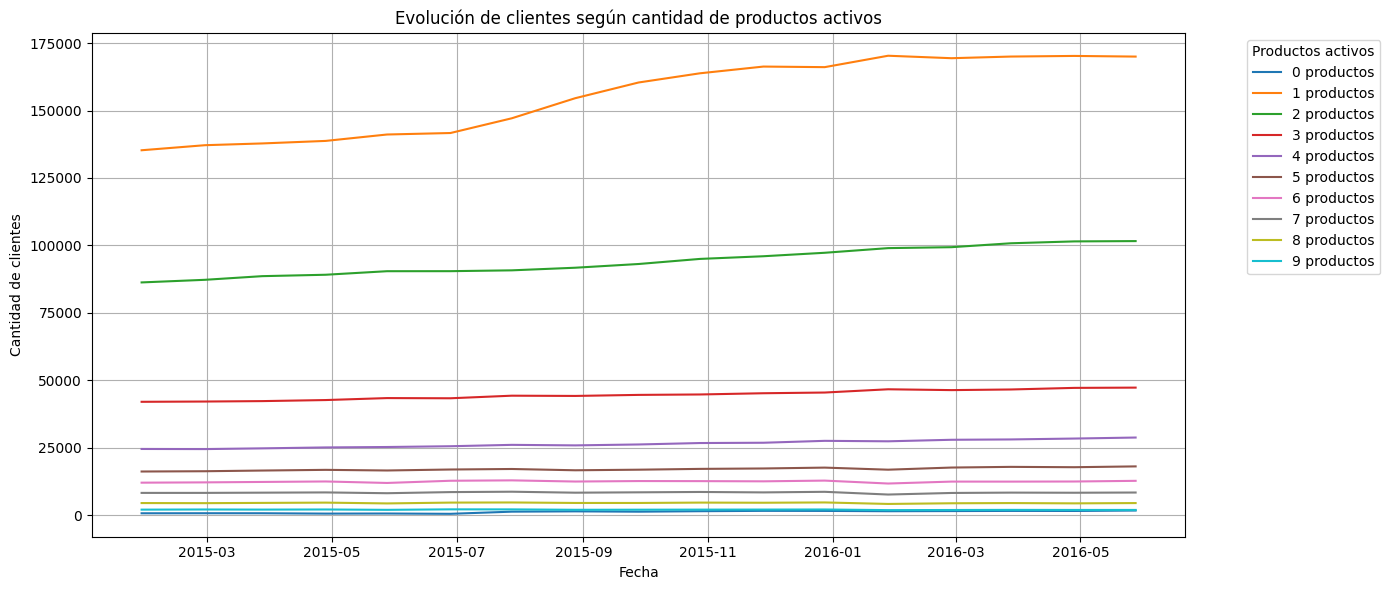

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el DataFrame 
df = df_conteo_productos  

# formato correcto
df['fecha_dato'] = pd.to_datetime(df['fecha_dato'])
df['total_productos_activos'] = df['total_productos_activos'].astype(int)

# Pivotear: filas = fechas, columnas = # productos, valores = # clientes
pivot_df = df.pivot_table(index='fecha_dato',
                          columns='total_productos_activos',
                          values='cantidad_clientes',
                          fill_value=0)

# Graficar
plt.figure(figsize=(14, 6))
for col in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[col], label=f'{col} productos')

plt.title('Evolución de clientes según cantidad de productos activos')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de clientes')
plt.legend(title='Productos activos', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


## Filtrar para revisar clientes con mas de 10 productos:

In [44]:
mas_10_prodcutos= '''
SELECT 
    total_productos_activos,
    COUNT(*) AS clientes
FROM (
    SELECT 
        ncodpers,
        (
            COALESCE(ind_ahor_fin_ult1, 0) +
            COALESCE(ind_aval_fin_ult1, 0) +
            COALESCE(ind_cco_fin_ult1, 0) +
            COALESCE(ind_cder_fin_ult1, 0) +
            COALESCE(ind_cno_fin_ult1, 0) +
            COALESCE(ind_ctju_fin_ult1, 0) +
            COALESCE(ind_ctma_fin_ult1, 0) +
            COALESCE(ind_ctop_fin_ult1, 0) +
            COALESCE(ind_ctpp_fin_ult1, 0) +
            COALESCE(ind_deco_fin_ult1, 0) +
            COALESCE(ind_deme_fin_ult1, 0) +
            COALESCE(ind_dela_fin_ult1, 0) +
            COALESCE(ind_ecue_fin_ult1, 0) +
            COALESCE(ind_fond_fin_ult1, 0) +
            COALESCE(ind_hip_fin_ult1, 0) +
            COALESCE(ind_plan_fin_ult1, 0) +
            COALESCE(ind_pres_fin_ult1, 0) +
            COALESCE(ind_reca_fin_ult1, 0) +
            COALESCE(ind_tjcr_fin_ult1, 0) +
            COALESCE(ind_valo_fin_ult1, 0) +
            COALESCE(ind_viv_fin_ult1, 0) +
            COALESCE(ind_nomina_ult1, 0) +
            COALESCE(ind_nom_pens_ult1, 0) +
            COALESCE(ind_recibo_ult1, 0)
        ) AS total_productos_activos
    FROM santander
    WHERE  ind_actividad_cliente = 1
) AS sub
WHERE total_productos_activos >= 10
GROUP BY total_productos_activos
ORDER BY total_productos_activos DESC;
'''

df_conteo_productos_great_10= pd.read_sql(mas_10_prodcutos, con)
df_conteo_productos_great_10

,total_productos_activos,clientes
0,15.0,9
1,14.0,26
2,13.0,230
3,12.0,1124
4,11.0,4343
5,10.0,12682


## Filtrando por ultimo trimestre, clientes activos para crear nueva bd 

In [ ]:
# Crear una nueva base de datos para el trimestree
con_nueva = sqlite3.connect("Proyecto_filtrada.db")

# Extraer el DataFrame desde la tabla filtrada
df_trimestre = pd.read_sql("""
SELECT *
FROM santander
WHERE fecha_dato IN ('2016-03-28', '2016-04-28', '2016-05-28')
  AND ind_actividad_cliente = 1
""", con)  #conexion a la bd principal a la que se le hace filtrado 

# Guardarlo en la nueva bd
df_trimestre.to_sql("santander_trimestre", con_nueva, index=False, if_exists="replace")

print("Creación de la nueva base de datos creada como 'Proyecto_filtrada.db'")

Creación de la nueva base de datos creada como 'Proyecto_filtrada.db'


In [14]:
# Conectar a la base de datos
con_two = sqlite3.connect("Proyecto_filtrada.db")
#  cuántas filas hay
total_two = pd.read_sql("SELECT COUNT(*) AS total_filas FROM santander_trimestre;", con_two)
print(total_two)


   total_filas
0      1183139


In [15]:
clientes_unicos_trimestre = """
SELECT COUNT(DISTINCT ncodpers) AS clientes_unicos
FROM santander_trimestre;
"""
df_clientes_trimestre = pd.read_sql(clientes_unicos_trimestre, con_two)
print(df_clientes_trimestre)


   clientes_unicos
0           405737


In [17]:
query = """
SELECT meses_registrados, COUNT(*) AS cantidad_clientes
FROM (
    SELECT ncodpers, COUNT(DISTINCT fecha_dato) AS meses_registrados
    FROM santander_trimestre
    GROUP BY ncodpers
) sub
GROUP BY meses_registrados
ORDER BY meses_registrados;
"""

df_resumen = pd.read_sql(query, con_two)
df_resumen

# hay 382.570 clientes con registros en los 3 meses 


,meses_registrados,cantidad_clientes
0,1,10905
1,2,12262
2,3,382570


## clientes que estén en los 3 meses

In [ ]:
clientes_en_trimestre = """
SELECT *
FROM santander_trimestre
WHERE ncodpers IN (
    SELECT ncodpers, COUNT(*) 
    FROM santander_trimestre
    GROUP BY ncodpers
    HAVING COUNT(DISTINCT fecha_dato) = 3
)
"""
df_clientes_trimestre = pd.read_sql(clientes_en_trimestre, con_two)

In [21]:
df_clientes_trimestre

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2016-03-28,466167,N,ES,H,60,2004-03-29,0.0,144,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,2016-03-28,1419835,N,ES,V,21,2015-07-28,0.0,8,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2016-03-28,1242168,N,ES,V,40,2014-02-06,0.0,25,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2016-03-28,1442576,N,ES,H,24,2015-09-06,0.0,6,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,2016-03-28,1442580,N,ES,V,47,2015-09-06,0.0,6,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147705,2016-05-28,1166759,N,ES,H,22,2013-08-14,0.0,33,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1147706,2016-05-28,1166761,N,ES,H,23,2013-08-14,0.0,33,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1147707,2016-05-28,1166779,N,ES,V,23,2013-08-14,0.0,33,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1147708,2016-05-28,1166778,N,ES,V,23,2013-08-14,0.0,33,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [ ]:
# queryy ='''
# select count(distinct(conteo)) from (
#     SELECT ncodpers, COUNT(*) conteo
#     FROM santander_trimestre
#     GROUP BY ncodpers
  
# ) as dfds
# '''


# dff= pd.read_sql(queryy,con_two)

### top 10 de productos para adquirir los productos mas adquiridos 
## 
